In [1]:
'''Parameters:
    - chemical composition (CO/CO2, etc.)
        - first use stationary snow lines to get an initial idea
    - migration of giant planets (start time and rate)
        - GOAL: find out how planetesimals move given planetary migration
            - take timescales (tau_a, tau_e) as ei/(ef-ei)/(tf-ti) tf = 1Myr
            - do not include inner planets, ensure comets are massless test particles
            - first fix Jupiter and Saturn at today's orbits, artificially migrate Neptune and Uranus
            - use Brasser's migration parameters (initial a and e as stated, final a and e as current solar system)
            - 2 simulations, one for comet bodies beyond Neptune, the other beyond Jupiter
            - plot histograms wrt a
    - initial distribution of comets
    - D/H ratio
    
    Comets uniformly distributed all the way from 10 to 45 AU, and define a CO2/CO function that should be 
    decreasing between 10 and 30 AU and attach the parameters to the comets. 
    Run the simulations for some time (Myr to see if it is working well). Then finally migrate Jupiter.
    '''

'Parameters:\n    - chemical composition (CO/CO2, etc.)\n        - first use stationary snow lines to get an initial idea\n    - migration of giant planets (start time and rate)\n        - do not include inner planets, ensure comets are massless test particles\n    - initial distribution of comets\n    - D/H ratio\n    \n    Comets uniformly distributed all the way from 10 to 45 AU, and define a CO2/CO function that should be \n    decreasing between 10 and 30 AU and attach the parameters to the comets. \n    Run the simulations for some time (Myr to see if it is working well). Then finally migrate Jupiter.\n    '

In [1]:
import numpy as np
import scipy as sp
import rebound
import reboundx
%matplotlib inline

In [ ]:
#Retrieve planet data from file
try:
     sim = rebound.Simulation.from_file("solarsystem.bin")
except:
     sim.add('sun')
     sim.add('jupiter')
     sim.add('saturn')
     sim.add('uranus')
     sim.add('neptune')
     sim.save("solarsystem.bin")

In [4]:
#Ignore for now

def chemratio(a):
     return 0.1005*a - 0.995

<rebound.Orbit instance, a=5.20277184958028 e=0.046867496202491365 inc=0.02820486227234875 Omega=2.0901821622204526 omega=0.2750632321832151 f=0.6794956213045524>
<rebound.Orbit instance, a=9.544683623291894 e=0.06298253624158848 inc=0.033892413059942096 Omega=1.3935602398098668 omega=-0.24904330962324742 f=-0.5272466328208144>
<rebound.Orbit instance, a=19.18113975971244 e=0.013231750615347156 inc=0.018298759932613824 Omega=1.1293587577665922 omega=-0.03866967067613044 f=-0.10933612993510067>
<rebound.Orbit instance, a=-97.38660622245501 e=82.50559392067683 inc=0.031749129592386974 Omega=2.2731491359950526 omega=-2.7231782773258506 f=1.5150012100539672>
<rebound.Orbit instance, a=19.69901216954889 e=0.13888095371746523 inc=0.07675231346243565 Omega=0.2470004167109504 omega=-2.8331614171378114 f=3.0754843091845823>
<rebound.Orbit instance, a=35.02532798542414 e=0.21112959519047184 inc=0.058129276964336264 Omega=1.7855567594410275 omega=-1.8624821119665236 f=2.428104234895779>
<rebound.

Widget(N=10, count=2, height=300.0, orbit_data=b'S\x82<\xc0yr\xaa\xc0\xcc\xfa8>\x1b}\xa6@"\xf8?=m\xf3-?\x17\xd5\x8c>\x8b\xc5\x05@\xe2\r\xe7<7\xd0<\xc0\xafn\xaa\xc0\x9f\x179>\x06\xb7\x18A\xfd\xfc\x80=\xa3\xf9\x06\xbf6\x05\x7f\xbe/`\xb2?\xc5\xd2\n=\xd6\xad<\xc0yb\xaa\xc0\x9a\x079>\xf9r\x99A\xfc\xc9X<\x9f\xeb\xdf\xbd\x17d\x1e\xbd\xd4\x8e\x90?H\xe7\x95<Q\xa6<\xc0\xda\\\xaa\xc0\x04\x079>\xf1\xc5\xc2\xc2\xdd\x02\xa5B\x8f\xeb\xc1?\x8eH.\xc0G{\x11@`\x0b\x02=\x92\xa8\x7f&\x00\x00\x00\x00m\xbe\xbf$\x94\x97\x9dA\xcf6\x0e>\xbc\xd4D@\x84R5\xc0\xad\xed|>Q0\x9d=\x92\xa8\x7f&\x00\x00\x00\x00m\xbe\xbf$\xf0\x19\x0cB[2X>\x0ff\x1b@\xd0e\xee\xbf \x8d\xe4?\xf7\x18n=\x92\xa8\x7f&\x00\x00\x00\x00m\xbe\xbf$\x15\x92Y\xc4\x90\xc5\x80?\xc2\x05B@=\xb2\xb3\xbe\x9b\x93h\xbf\xdc\xf2\xd9<\x92\xa8\x7f&\x00\x00\x00\x00m\xbe\xbf$\xec\x9cBB\x15\x88S>Q\xb1\x01@wh\xba>\xd5n\x96?!\xd67=\x92\xa8\x7f&\x00\x00\x00\x00m\xbe\xbf$"\x02S\xc4\x8c\xcd\x80?,@P\xc0}\xbc\xde>s\x01\x1f\xc0\x8e\xc3.>', orbits=True, orientation=(0.0, 0.0, 0.0, 1.0), overlay='REBOUND (ias15), N=10, t=1e+06', particle_data=b'S\x82<\xc0yr\xaa\xc0\xcc\xfa8>enD:\x00\r\r;kr\x81\xb8\x00\x00\x00\x00\xe0\xbc\xfd\xc0\x19\xec\x9a\xc0\x0f\x82\x97>\x9eK\xb6\xbe\xfc|5\xc09PF=\x00\x00\x00\x00l\xc0\x8c@\x05\xa5\xda\xbd\x05i\x08\xbd#\xde\xa5\xbf\x8f\x89\xdb?\xf8$[=\x00\x00\x00\x00\xee]\xf2@n\x90&Au\xba\x04>\xbe\xe0\x9a\xbf\x01\x83N?h\xb0\xd7<\x00\x00\x00\x00\x10\xce_G2\x1c\xcaG\xf5\x81[\xc5\xf2R\x8a>\xe0\xc5\x13?\xde\xac\x96\xbc\x00\x00\x00\x00id\x9eA>j(AuE\xd3>\n\x15\x11\xbf\xcb\x90\x8b?+W\xbc=\x00\x00\x00\x00o\xd8\xdf\xc1\xc2r\xe2A\x10\xb4\x9e?*\xda@\xbf\xb8\x1a\t\xbf&\xa6J=\x00\x00\x00\x00K\xec#\xc7\xfc\xa4HHa\x18\x1bE\xbc\xca/\xbd\xb5\xacV>\xca\xcd%;\x00\x00\x00\x00\xfc\xa4:\xc2d\xce\xa8\xc1\x03\xcb\xc8?\x7f\x05A>\xf6ZU\xbf\xe7$\xb6\xbc\x00\x00\x00\x00#\x9a\xa9G\xb7g\xfaGX\x82\x02\xc6\xb2O\xf9=zH8>\x8e]@\xbc\x00\x00\x00\x00', scale=54.09, t=1000000.0, width=500.0)

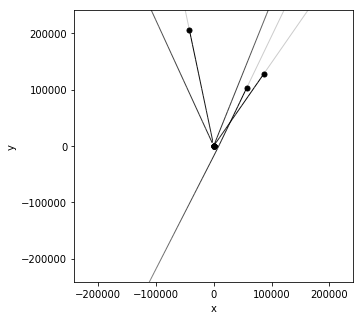

In [5]:
#Call simulations stuffs
sim = rebound.Simulation()
sim.integrator = "ias15"
sim.units = ('yr', 'AU', 'Msun')
a_neptune = 30.05

tmax = 1e6
n_comets = 5

#Call reboundx for additional forces
rebx = reboundx.Extras(sim)
#Add in force that determines planet migration
rebx.add("modify_orbits_forces")

#Set the semi-major axis and eccentricity timescales for Uranus and Neptune only
#Timescale determined by equation: tau_a = ai/((af-ai)/(tf-ti)) (tf = 1Myr, ti = 0)
a_f_list = [5.2044, 9.5826, 19.2184, 30.1104]
a_i_list = [5.2044, 9.5826, 17.5, 27.5]
e_f_list = [0.0489, 0.0565, 0.0463, 0.00946]
e_i_list = [0.0489, 0.0565, 0.2, 0.3]
sim.particles[3].params["tau_a"] =  a_i_list[3]/((a_f_list[3]-a_i_list[3])/(1e6))
sim.particles[4].params["tau_a"] =  a_i_list[4]/((a_f_list[4]-a_i_list[4])/(1e6))

a_comets = np.random.uniform(low = 10., high = 45. , size = n_comets)

for i in xrange(0,n_comets):
     rand = np.random.random()*2*np.pi
     sim.add( a=a_comets[i], e=0.15, inc=0., Omega=0, omega=rand, f=rand )
     sim.particles[-1].params["CO/CO2"] = chemratio(a_comets[i])
        
        
sim.exit_max_distance=1e6


sim.integrate(tmax)
sim.move_to_com()

In [ ]:
#Run simulation
orbits = sim.calculate_orbits()
for orbit in orbits:
     print(orbit)

In [ ]:
#Plot widgets
fig = rebound.OrbitPlot(sim)
sim.getWidget(size=(500,300),scale=1.8*a_neptune)